In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import regex as re
import numpy as np

from read_1t1r_data import read_1t1r_data

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

recursively search the folder for excel files starting with 'Prog'

these files contain data collected during multiple set/reset operations across multiple 1T1R devices

the most important components of this data are HRS and LRS values as a function of the current and the voltage at the gate during set/reset

In [11]:
_, prog_data = read_1t1r_data(dir='.', type='Prog')

print(f"{len(prog_data)} devices tested using the analog programming test method Prog")

27 devices tested using the analog programming test method Prog


each device contains data with the following keys, these can also be thought of as column labels where each row is an operation (set/reset/read):

In [12]:
print(f'column labels: {prog_data[0].keys()}')

column labels: dict_keys([1, 'LRS', 'HRS', 'setv', 'resetv', 'gatev', 'vread', 'LRSreadi', 'HRSreadi', 'seti', 'reseti'])


lets plot LRS vs. gate voltage used during set for device 0 in log scale

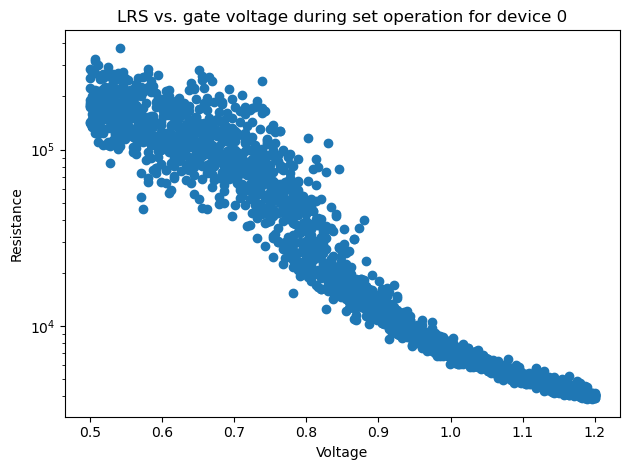

In [13]:
test_device = 0
test_LRS = prog_data[test_device]['LRS']
test_gatev = prog_data[test_device]['gatev']

plt.title(f'LRS vs. gate voltage during set operation for device {test_device}')
plt.scatter(test_gatev, test_LRS)
plt.ylabel('Resistance')
plt.xlabel('Voltage')
plt.yscale('log')
plt.show()

to better understand the way the data was collected, lets plot the LRS values in the order they were collected. (LRS vs cycle)

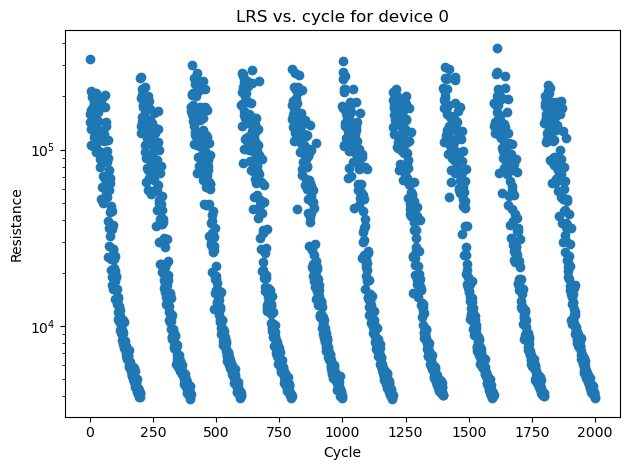

In [14]:
plt.title(f'LRS vs. cycle for device {test_device}')
plt.scatter(range(len(test_LRS)), test_LRS)
plt.ylabel('Resistance')
plt.xlabel('Cycle')
plt.yscale('log')
plt.show()


above shows the LRS values after each set operation. Each device(1T1R) was subject to 10 groups of set/reset cycles. Each group contains 200 different LRS values which each correspond to different voltages used at the gate during set operations. This way we have 10 points to average from for each device. the voltage ranges from 0.5V to 1.2V

In [15]:
print(f"min: {np.min(prog_data[test_device]['gatev'])} V")
print(f"max: {np.max(prog_data[test_device]['gatev'])} V")

min: 0.5 V
max: 1.2 V


Now we will create a box plot of LRS vs. voltage value across device 0

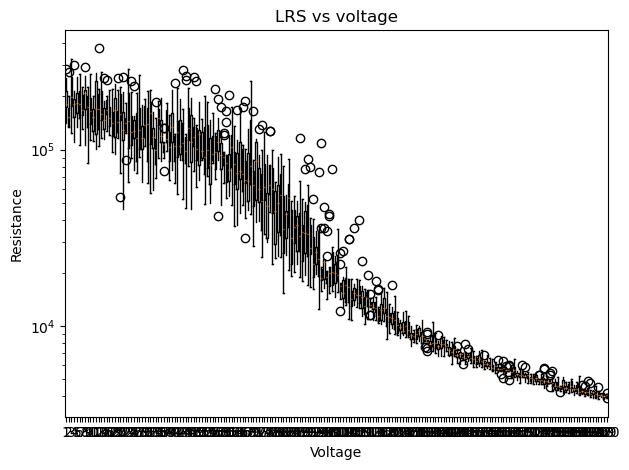

In [16]:
LRS_by_voltage = []

# for each voltage value
for v_i in range(200):
    LRS_by_voltage.append([])

    # grab the LRS from each group
    for group_j in range(10):
        LRS_by_voltage[-1].append(prog_data[test_device]['LRS'][v_i + group_j*200])

plt.title('LRS vs voltage')
plt.boxplot(LRS_by_voltage)
plt.yscale('log')
plt.ylabel('Resistance')
plt.xlabel('Voltage')
plt.show()

Instead of making a box for each of the 200 voltages, we can combine resistance values from multiple voltages.

In [19]:
def test_singledevice(d,t, x_single, LRS_res, LRS_x, LRS_res_final, LRS_x_final, n_samples):
    avg_resistance = []
    avg_x = []
    sample=0
    final_idx = 0

    res_single = d['LRS'] 
    x_single = d[t]

    for i in range(0,200,1):
        lrs_res = []
        lrs_x = []
        for j in range(10):
            lrs_res.append(res_single[200*j+i])
            lrs_x.append(x_single[200*j+i])
        LRS_res[i] += lrs_res
        LRS_x[i] += lrs_x
    

    for (i, res), x in zip(enumerate(LRS_res),LRS_x) : #list of res
        avg_resistance += res
        avg_x += x
        sample += 1

        if sample == n_samples:
            LRS_res_final[final_idx] += avg_resistance
            LRS_x_final[final_idx] += avg_x
            final_idx+=1
            sample = 0
            avg_resistance=[]
            avg_x=[]



def plot(t):
    LRS_res = []
    LRS_x = []
    LRS_res_final = []
    LRS_x_final = []

    for i in range(0,200,1):
        LRS_res.append([])
        LRS_x.append([])


    n_samples=8
    for i in range(0,int(200/n_samples),1):
        LRS_res_final.append([])
        LRS_x_final.append([])

    x_single = []
    
    for i in range(len(prog_data)):
        test_singledevice(prog_data[i], t,  x_single, LRS_res, LRS_x, LRS_res_final, LRS_x_final, n_samples)

    # print(len(gatevs_single))
    # print(len(LRS_gatevs))
    LRS_x_final = np.average(LRS_x_final,1)
    fig = plt.subplots(1,1,figsize=(8,5),dpi=600)
    if t == 5:
        print(len(np.arange(0.5, 1.25, 0.05)))
        print(len(LRS_res_final))
        # plt.boxplot(LRS_res_final,showfliers= False,widths=0.015,positions=np.arange(0.5, 1.25, 0.05))
        plt.boxplot(LRS_res_final,showfliers= False,widths=0.015,positions=np.round(LRS_x_final,4))
        plt.xlabel('Voltage (V)')
        plt.xlim(0.75,1.25)
    if t == 9:
        w = 10.25
        width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
        plt.boxplot(LRS_res_final,showfliers= False,widths=width(LRS_x_final, w),positions=1e6*LRS_x_final)
        plt.xscale("log")
        plt.xlabel('Current (uA)')
        #plt.xlim(0.122,161)
    plt.yscale("log")
    plt.ylabel(r'Resistance ($\Omega$)')
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='small'  
    )
    
    #plt.ylim(0,25000)
    plt.savefig('res_vs_vnset.pdf', bbox_inches='tight')
    plt.show()



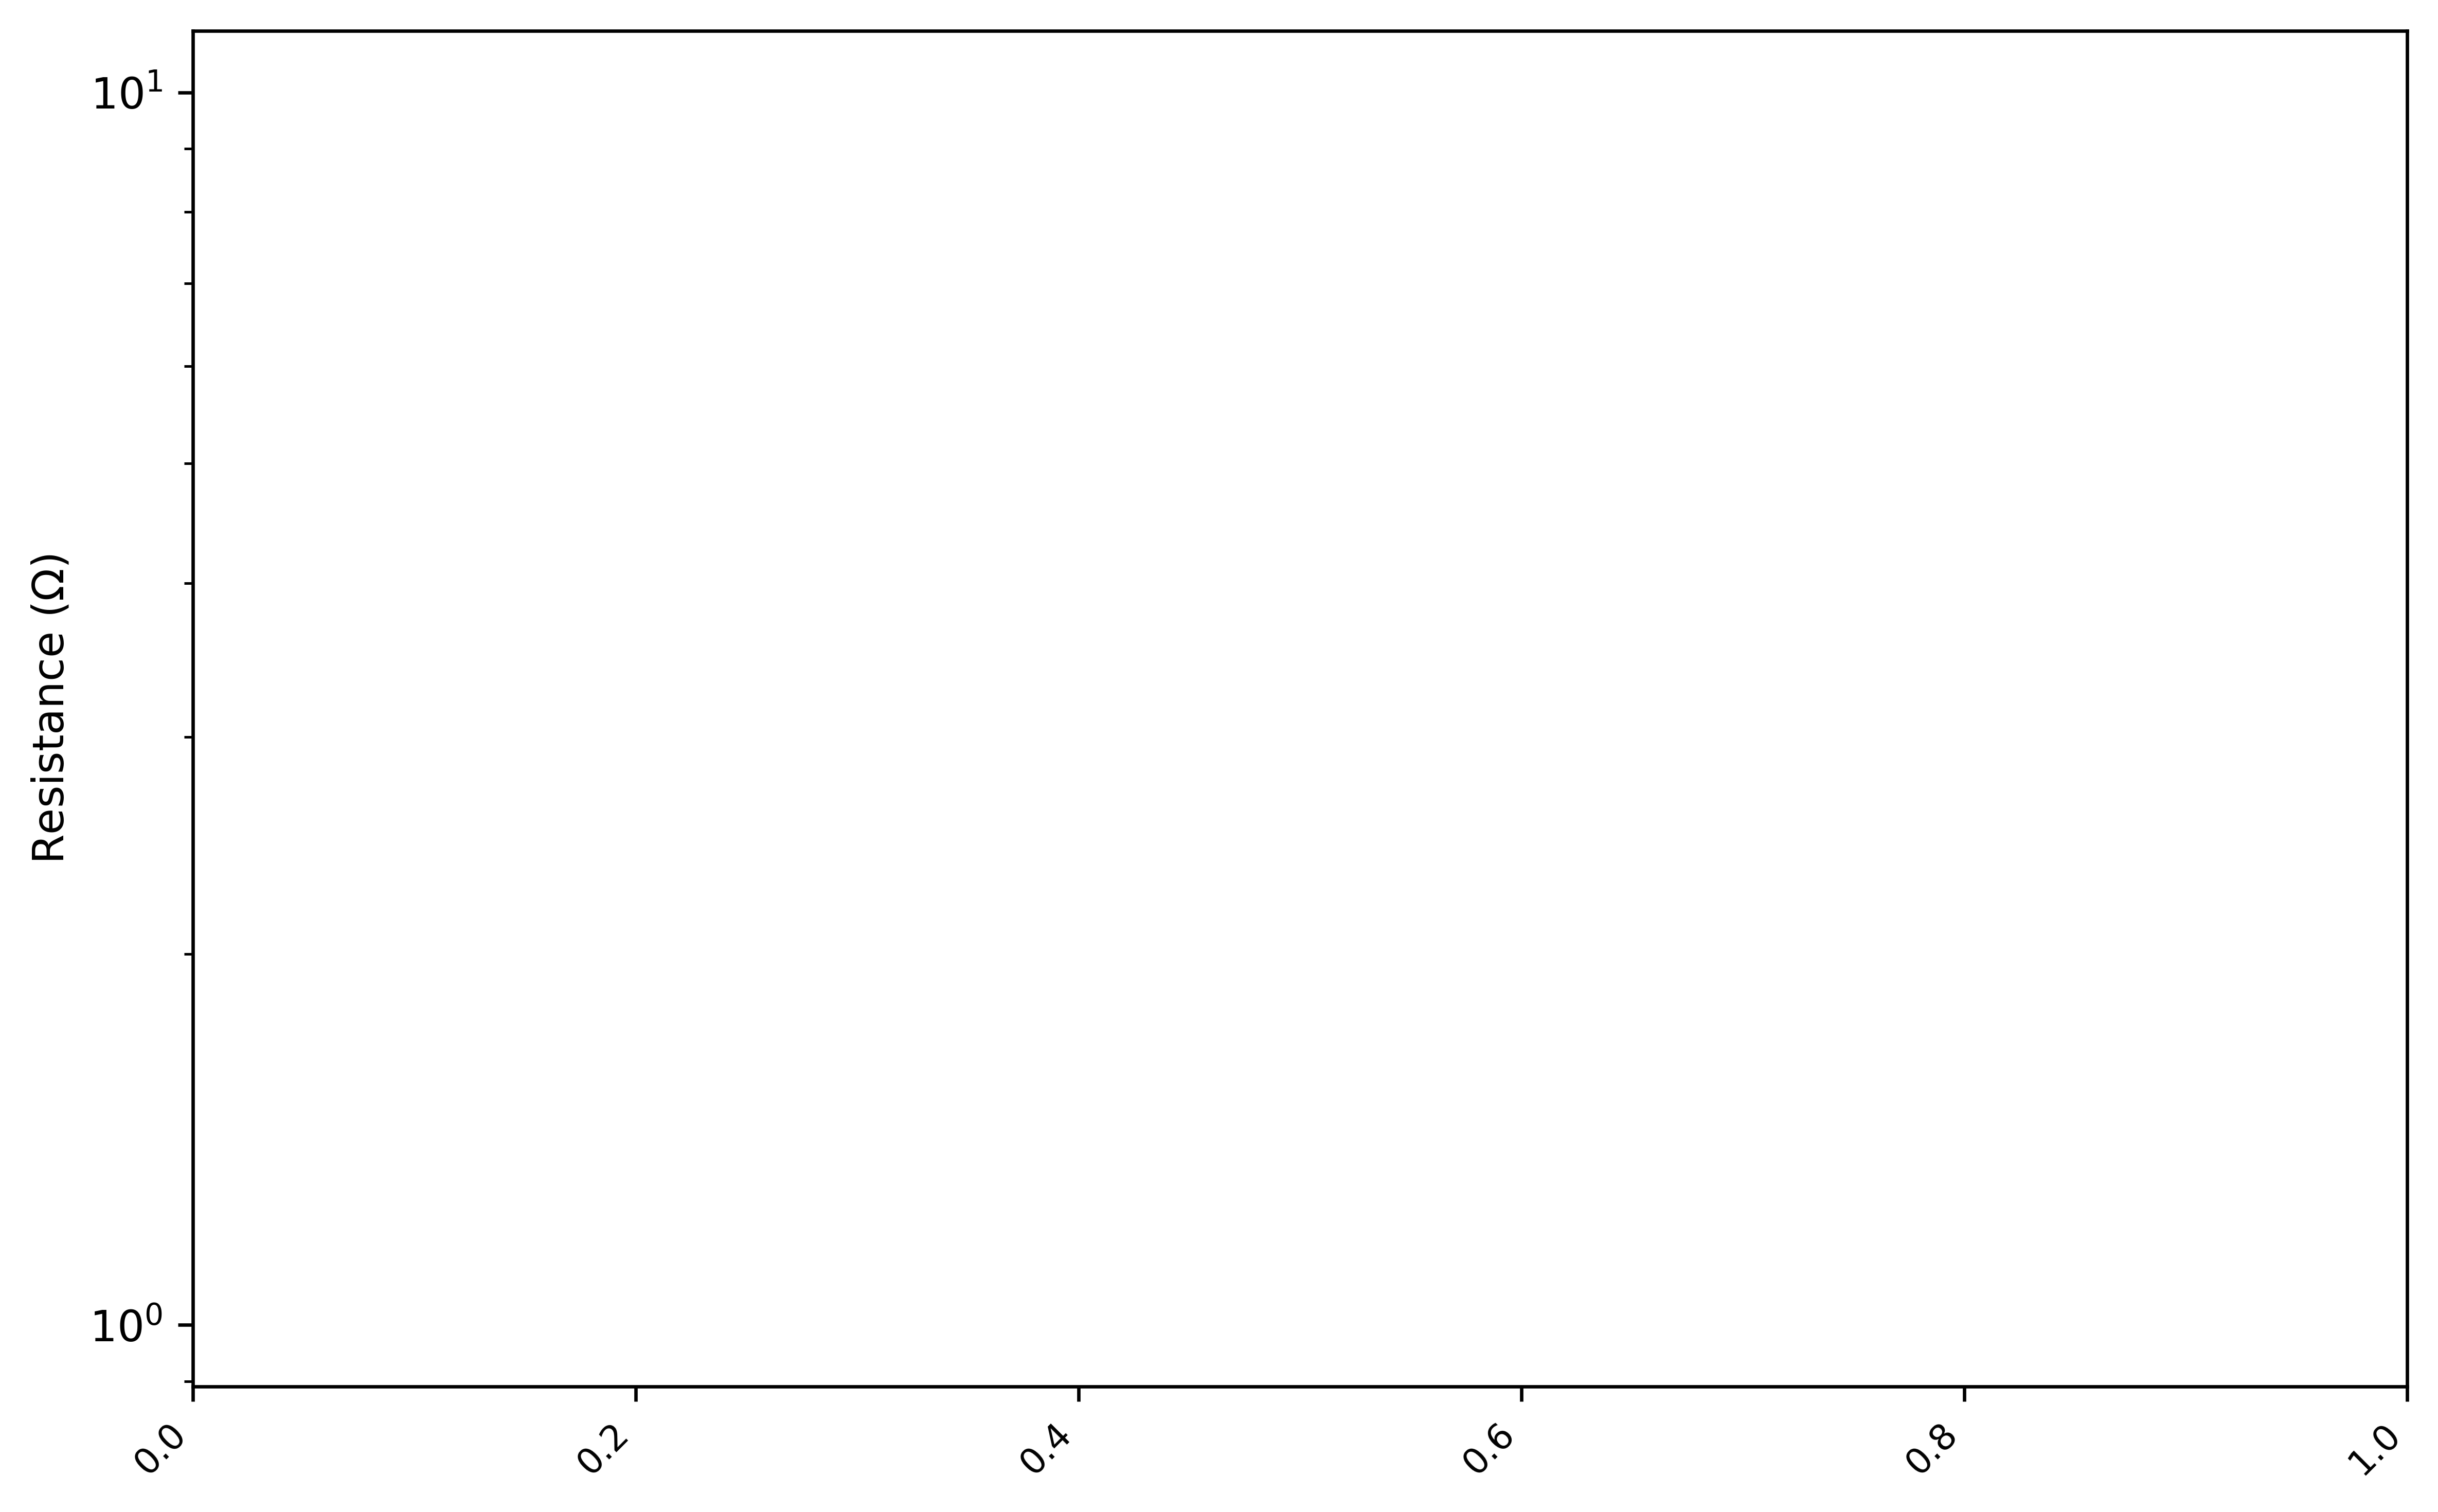

In [20]:
plot('gatev')
# plot(9)

In [ ]:
# len(np.average(LRS_x_final,1))